In [1]:
import torch
import torch.nn as nn
import torchvision

from going_modular import data_setup, engine, utils

from timeit import default_timer as timer

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

device

'cuda'

In [3]:
import os
import zipfile
import requests

from pathlib import Path


data_path = Path('data')
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not found {image_path} directory, creating one...")
    image_path.mkdir(parents= True, exist_ok = True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)
    
    os.remove(data_path/"pizza_steak_sushi.zip")
    

data\pizza_steak_sushi directory exists.


In [4]:
train_dir = image_path/"train"
test_dir = image_path/"test"

In [5]:
from torchvision import transforms

manual_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

In [6]:


train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir= train_dir, 
                                                                               test_dir= test_dir, 
                                                                               transform= manual_transform,
                                                                               batch_size= 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x10ad19ce0c0>,
 ['pizza', 'steak', 'sushi'])

when using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

And now to access the transforms associated with our weights, we can use the *transforms()* method.

This is essentially saying "get the data transforms that were used to train the *EfficientNet_B0_Weights* on ImageNet".


In [8]:
# Get the transforms used to create our pretrained weights
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
train_dataloader , test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir, 
                                                                                test_dir = test_dir, 
                                                                                transform = auto_transform,
                                                                                batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x10ad1b736b0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
# Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights= weights).to(device)

In [11]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [22]:
from torchinfo import summary

summary(model= model,
        input_size= (32, 3, 224, 224),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width= 20,
        row_settings= ["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

We can freeze all of the layers/parameters in the features section by setting the attribute *requires_grad=False*.

For parameters with *requires_grad=False*, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with *requires_grad=False* is *"untrainable"* or *"frozen"* in place.

In [13]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False     # Feature extractor layers frozen!


Let's now adjust the output layer or the classifier portion of our pretrained model to our needs.

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features= 1280,
                    out_features= output_shape,
                    bias= True)).to(device)

In [15]:
summary(model, input_size=(32, 3, 224, 224),
        verbose= 0,
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Trani Model

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model.parameters(), lr= 1e-3)

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

results = engine.train(model= model,
                       train_dataloader= train_dataloader,
                       test_dataloader= test_dataloader,
                       optimizer= optimizer,
                       loss_fn= loss_fn,
                       epochs= 5,
                       device= device)
end_time = timer()

print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0962 | train_acc: 0.3906 | test_loss: 0.9144 | test_acc: 0.5909
Epoch: 2 | train_loss: 0.8708 | train_acc: 0.7695 | test_loss: 0.7918 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.7686 | train_acc: 0.7930 | test_loss: 0.7461 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7167 | train_acc: 0.7422 | test_loss: 0.6369 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6291 | train_acc: 0.7695 | test_loss: 0.6272 | test_acc: 0.8968
[INFO] Total training time: 79.503 seconds


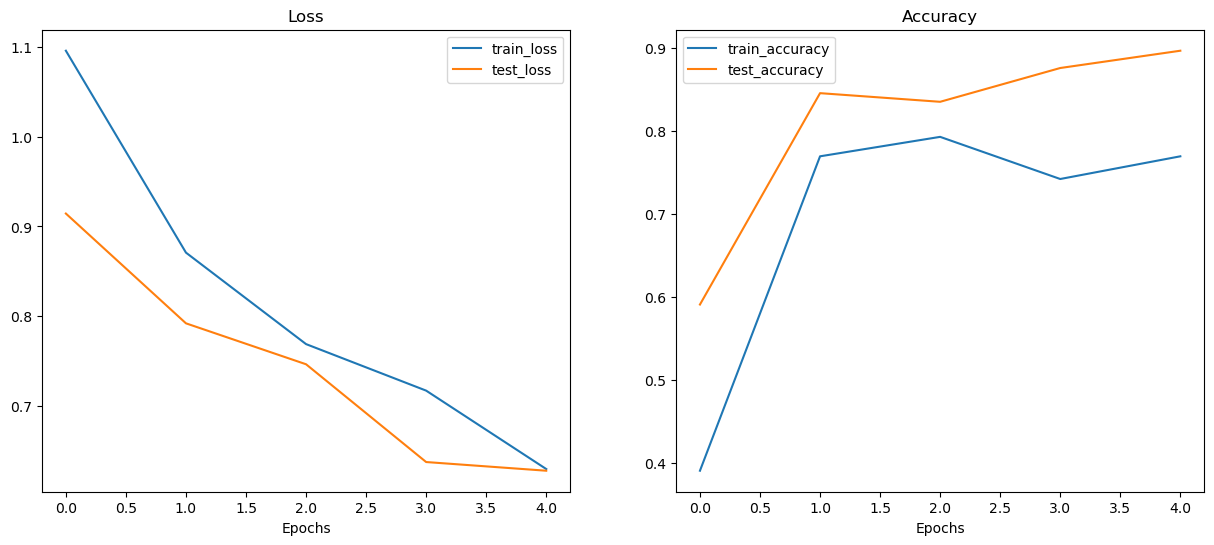

In [18]:
utils.plot_loss_curves(results= results)

### Make predictions on images from the test set

In [1]:
# %%writefile -a going_modular/predictions.py
from typing import List, Dict, Tuple
from PIL import Image
import matplotlib.pyplot as plt

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_plot_image(model: torch.nn.Module,
                    image_path: str,
                    class_names: List[str],
                    image_size: Tuple[int, int] = (224, 224),
                    transform: torchvision.transforms = None,
                    device: torch.device = device):
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else: 
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])
            ])
        
    # Predict on Image
    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():

        # 6. transform and add an extra dimension to image
        transformed_image = image_transform(img).unsqueeze(dim = 0)

        # 7. Make prediction
        target_image_pred = model(transformed_image.to(device))
    
    # 8. Convert Logits -> prediction probibilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probibilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probibility
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

Writing going_modular/predictions.py


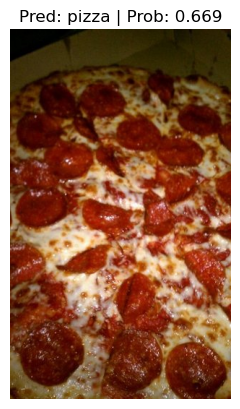

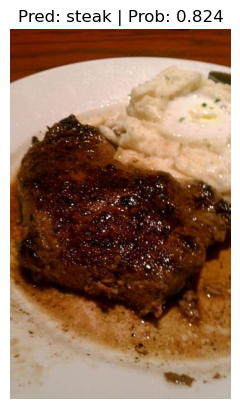

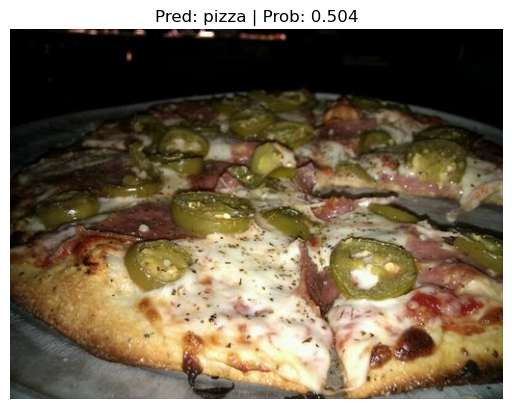

In [26]:
# Get a random list of image paths from test set

import random

num_image_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, k = num_image_to_plot)

# Make predictions and plot the images
for image_path in test_image_path_sample:
    pred_plot_image(model= model,
                    image_path= image_path,
                    class_names= class_names,
                    transform= weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                    image_size= (224, 224))

### Making predictions on a custom image

data\04-pizza-dad.jpeg already exists.


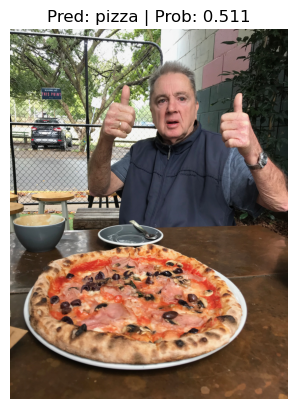

In [30]:
import requests

custom_image_path = data_path/"04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloadig {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists.")

pred_plot_image(model= model, 
                image_path= custom_image_path,
                class_names= class_names)